# Prevendo intervalos para valores de licenciamento

#### Este notebook faz o treinamento e predição de intervalos de valores de licenciamento para novos títulos.

Neste notebook utilizei três modelos para criar os intervalos, todos lightgbm mas treinados com funções objetivo diferentes.

O primeiro modelo é um modelo tradicional, onde utilizo dados de treino para treinar o modelo utilizando uma função de regressão. Os outros dois modelos são para prever o valor inferior do intervalo e o valor superior do intervalor. Ambos utilizam o lightgbm mas com uma função objetivo de quantil, disponível [aqui](https://en.wikipedia.org/wiki/Quantile_regression).

O modelo de quantis precisa de um hyperparâmetro que representa o limite do quantil desejado. Por isso utilizei dois modelos. Neste desafio este parâmetro foi atribuido como 0.95 (95%), o que significa que o modelo consegue calcular um intervalo de confiânça onde 95% das vezes que escolhermos um valor para a predição este valor está dentro deste intervalo.

Ao longo do notebook descrevo todos os passos tomados e análises feitas. O arquivo [relatorio](relatorio.pdf) contem um relatório que reflete este notebook e todas as análises feitas.

In [1]:
#Imports necessário para o notebook

from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error as mae
import numpy as np
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

In [2]:
#Lendo os dados de treino e teste
data = pd.read_excel('catálogo conteúdo, globoplay (2).xlsx')

Nos dados que devo utilizar para prever os valores as colunas que eu removo abaixo não estão presentes. Uma opção seria colocar valores nulos para todos os campos ou não utilizá-las no treinamento, decidi não utilizá-las.

In [3]:
#Removendo colunas que não existem nos dados de predição
data = data.drop(columns=['Total Video Views In Milions', 'Total Hours Watched In Milions'])
data.head()

,Title,Genre,Release Year,Duration Minutes,Country,Production Cost In Milions,Licensing Cost Milions
0,Wife Behind You,Horror,2019,83,Brasil,22.31,10.0395
1,Fool Strategy,Humor,2020,71,Catar,13.00,6.5000
2,Door In The Forest,Children,2020,95,Egito,119.91,45.5658
3,Owl In The Lake,Horror,2015,67,Arábia Saudita,81.12,25.1472
4,Agents Of Heaven,Adventure,2015,73,Coreia do Sul,29.34,10.8558


In [4]:
#Criando encoders ordinais para cada uma das variáveis categóricas
release_year_enc = OrdinalEncoder()
data['Release Year'] = release_year_enc.fit_transform(data['Release Year'].to_numpy().reshape(-1, 1)).astype('int')

country_enc = OrdinalEncoder()
data['Country'] = country_enc.fit_transform(data['Country'].to_numpy().reshape(-1, 1)).astype('int')

genre_enc = OrdinalEncoder()
data['Genre'] = genre_enc.fit_transform(data['Genre'].to_numpy().reshape(-1, 1)).astype('int')

In [5]:
#Separando variaveis de entrada e saída
X = data.drop(columns=['Licensing Cost Milions'])
y = data['Licensing Cost Milions']

In [6]:
#Criando divisão de treino e teste, 10% para o teste
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.10, random_state=42)

#Armazenando títulos das linhas de teste para mostrar nos gráficos
test_titles = X_test['Title']

#Removendo titulos das variaveis de entrada, porque são inúteis
X_train = X_train.drop(columns=['Title'])
X_test = X_test.drop(columns=['Title'])

O lightgbm é um modelo de boosting, ou seja utiliza um conjunto de preditores "burros" para criar uma predição boa. Lightgbm e o Xgboost são muito utilizados para tarefas de regressão e apresentam resultados bem similares, no entanto o lightgbm consome muito menos memória para realizar seu treinamento, por isso o escolhi.

Utilizei um modelo regressor, porque desejamos encontrar o valor do custo de licenciamento.

Durante meu tempo como acadêmico e como cientista de dados no mercado, em todas as vezes os hyperparâmetros padrões do lightgbm foram tão bons quanto hyperparâmetros otimizados, por isso não realizei otimização destes hyperparâmetros.

In [7]:
#Criação do objeto
regressor = LGBMRegressor()
#Treino do modelo
regressor.fit(X_train, y_train)
#Predição do conjunto de teste
regressor_pred = regressor.predict(X_test)

Na célular abaixo crio os dois modelos para os limites do intervalo de confiança. Um para o limite inferior e outro para o limite superior.

In [8]:
#Hyper parâmetro para o intervalo
alpha = 0.95

#Modelo para valor mínimo
lower = LGBMRegressor(objective = 'quantile', alpha = 1 - alpha)
lower.fit(X_train, y_train)
lower_pred = lower.predict(X_test)

#Modelo para valor máximo
upper = LGBMRegressor(objective = 'quantile', alpha = alpha)
upper.fit(X_train, y_train)
upper_pred = upper.predict(X_test)

Abaixo temos algumas estatísticas sobre o modelo.

O teste r2 representa o quanto da variância dos dados o modelo consegue explicar. Neste caso, com o valor de ~0.82 conseguimos explicar aproximadamente 82% da variância.

O Mean Absolute Error representa o erro médio absoluto. Neste caso podemos ver que, em média, nosso erro está em torno de três milhões e seiscentos mil.

In [9]:
print('r2', f'{r2_score(y_test, regressor_pred):.2f}')
mae_error = mae(y_test, regressor_pred)
print('mae', f'{mae_error:.2f}')

r2 0.82
mae 3.61


Neste gráfico podemos ver um histograma com a distribuição dos erros. Podemos ver que 95% dos erros atigem no máximo 10 milhões individualmente e acumulados totalizam 19 milhões.

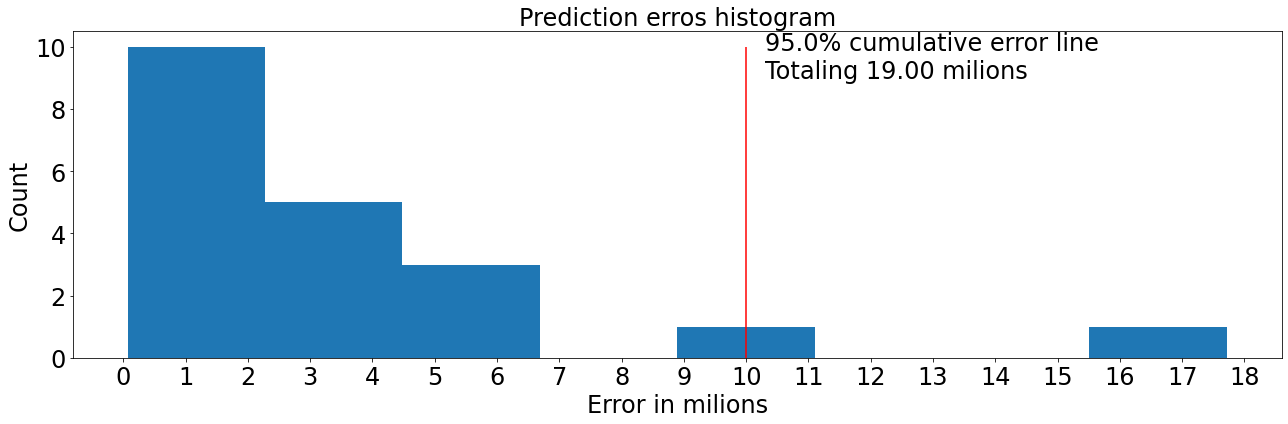

In [10]:
errors = np.abs(y_test - regressor_pred)
plt.figure(figsize=(18, 6))
n, bins, patches = plt.hist(errors, bins='auto')#y_test.shape[0])
plt.title('Prediction erros histogram', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.xlabel('Error in milions', fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(np.arange(0, int(np.ceil(errors.max()))+1), fontsize=24)

element = 0.95
cumsum = list(np.cumsum(n)/np.sum(n))

# finding the index of element
index = cumsum.index(element)

# printing the final index
point = index/len(n)
point = point*int(np.ceil(errors.max()))+1

plt.vlines(point, ymin=0, ymax=np.max(n), color='red')
plt.annotate(f'{element*100}% cumulative error line\nTotaling {np.cumsum(n)[index]:.2f} milions',
            (point+0.3, np.max(n)-1), fontsize=24)
plt.tight_layout()
plt.savefig('errors_histogram.png', dpi=600)
plt.show()

Este gráfico representa a relação entre os valores previstos e reais do modelo criado. A linha preta representa um cenário ideal onde todos os valores previstos são iguais aos valores reais.

Os pontos coloridos de vermelho são pontos onde o erro é maior que o erro médio absoluto e os pontos coloridos de azul são pontos
onde o erro é menor que o erro médio absoluto.

Podemos ver dois outliers.

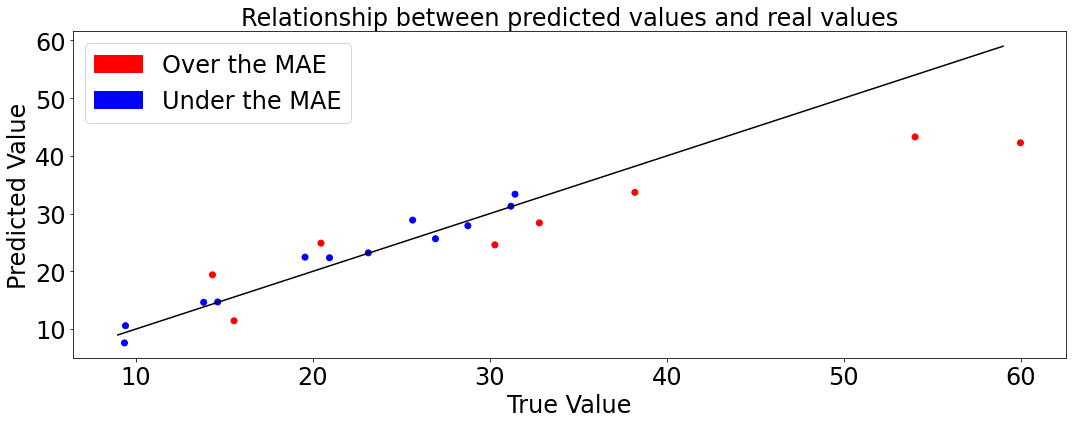

In [11]:
errors_colors = []

for error in errors:
    if error > mae_error:
        errors_colors.append('red')
    else:
        errors_colors.append('blue')

plt.figure(figsize=(15, 6))
plt.scatter(y_test, regressor_pred, c=errors_colors)
plt.plot(range(int(np.floor(np.min(y_test))), int(np.ceil(np.max(y_test)))),range(int(np.floor(np.min(y_test))), int(np.ceil(np.max(y_test)))), color='black')
plt.title('Relationship between predicted values and real values', fontsize=24)
plt.xlabel('True Value', fontsize=24)
plt.ylabel('Predicted Value', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

location = 0 # For the best location
legend_drawn_flag = True
red = Circle('Red', color='Red')
blue = Circle('Blue', color='Blue')
plt.legend(handles=[red, blue], labels=['Over the MAE', 'Under the MAE'], loc=0, frameon=legend_drawn_flag, fontsize=24)
plt.tight_layout()
plt.savefig('errors_scatter.png', dpi=600)
plt.show()

Esses dois outliers são os títulos "Surprise With Honor" e "Foreigner Of Light".

Podemos ver abaixo seus dados de gênero, ano de criação e país.

Ao criamos histogramas destas três categorias podemos ver que os dados de gênero são extremamente bem distribuídos, o que significa que provavelmente não são o que está causando o erro na predição.

Quando analisamos o ano de criação podemos ver que existe um desbalanceamento destes anos. No entanto, a quantidade de exemplos com os anos que os dois outliers pertencem é significativa, então não podemos afirmar que o problema na predição vem da falta de exemplos com os anos afirmados.

O mesmo acontece com o país de origem, não existe um problema claro de falta de exemplos.

Analisando estas variáveis acredito que o problema venha de variáveis não mensuradas e não utilizadas no modelo, como, por exemplo, presença de atores famosos etc.

In [12]:
outliers = sorted(y_test)[-1], sorted(y_test)[-2]
for outlier in outliers:
    index = list(y_test).index(outlier)
    print(data[data['Title']==test_titles.iloc[index]][['Title', 'Genre', 'Release Year', 'Country']])

                   Title  Genre  Release Year  Country
66   Surprise With Honor      3             1       17
                   Title  Genre  Release Year  Country
137   Foreigner Of Light      6             0       24


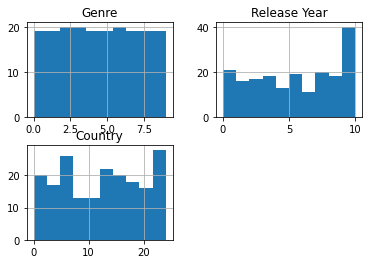

In [13]:
ax = data.drop(columns=['Title', 'Duration Minutes', 'Production Cost In Milions', 'Licensing Cost Milions']).hist()
ax[0][0].figure.savefig('variables_histogram.png')

O gráfico abaixo mostra os intervalos preditos para os dados de teste. 

O ponto verde representa o valor mínimo do intervalo, a faixa verde representa todos os valores abaixo do valor sugerido pelo modelo como valor real do custo de licenciamento. 

O ponto vermelho representa o valor máximo do intervalo, a faixa vermelha representa todos os valores acima do valor sugerido pelo modelo como valor real do custo de licenciamento.

A cruz azul representa o valor sugerido pelo modelo e o ponto preto representa o valor real.

Podemos ver que para 65% dos casos de teste o modelo conseguiu criar um intervalo onde o valor real está dentro deste intervalo. Neste exemplos não é plotado o valor real.

Para os outros 35% dos casos podemos ver que o intervalo não inclui o valor real, no entanto para cinco dos sete casos onde o intervalo não inclui o valor real a diferença é pequena. 

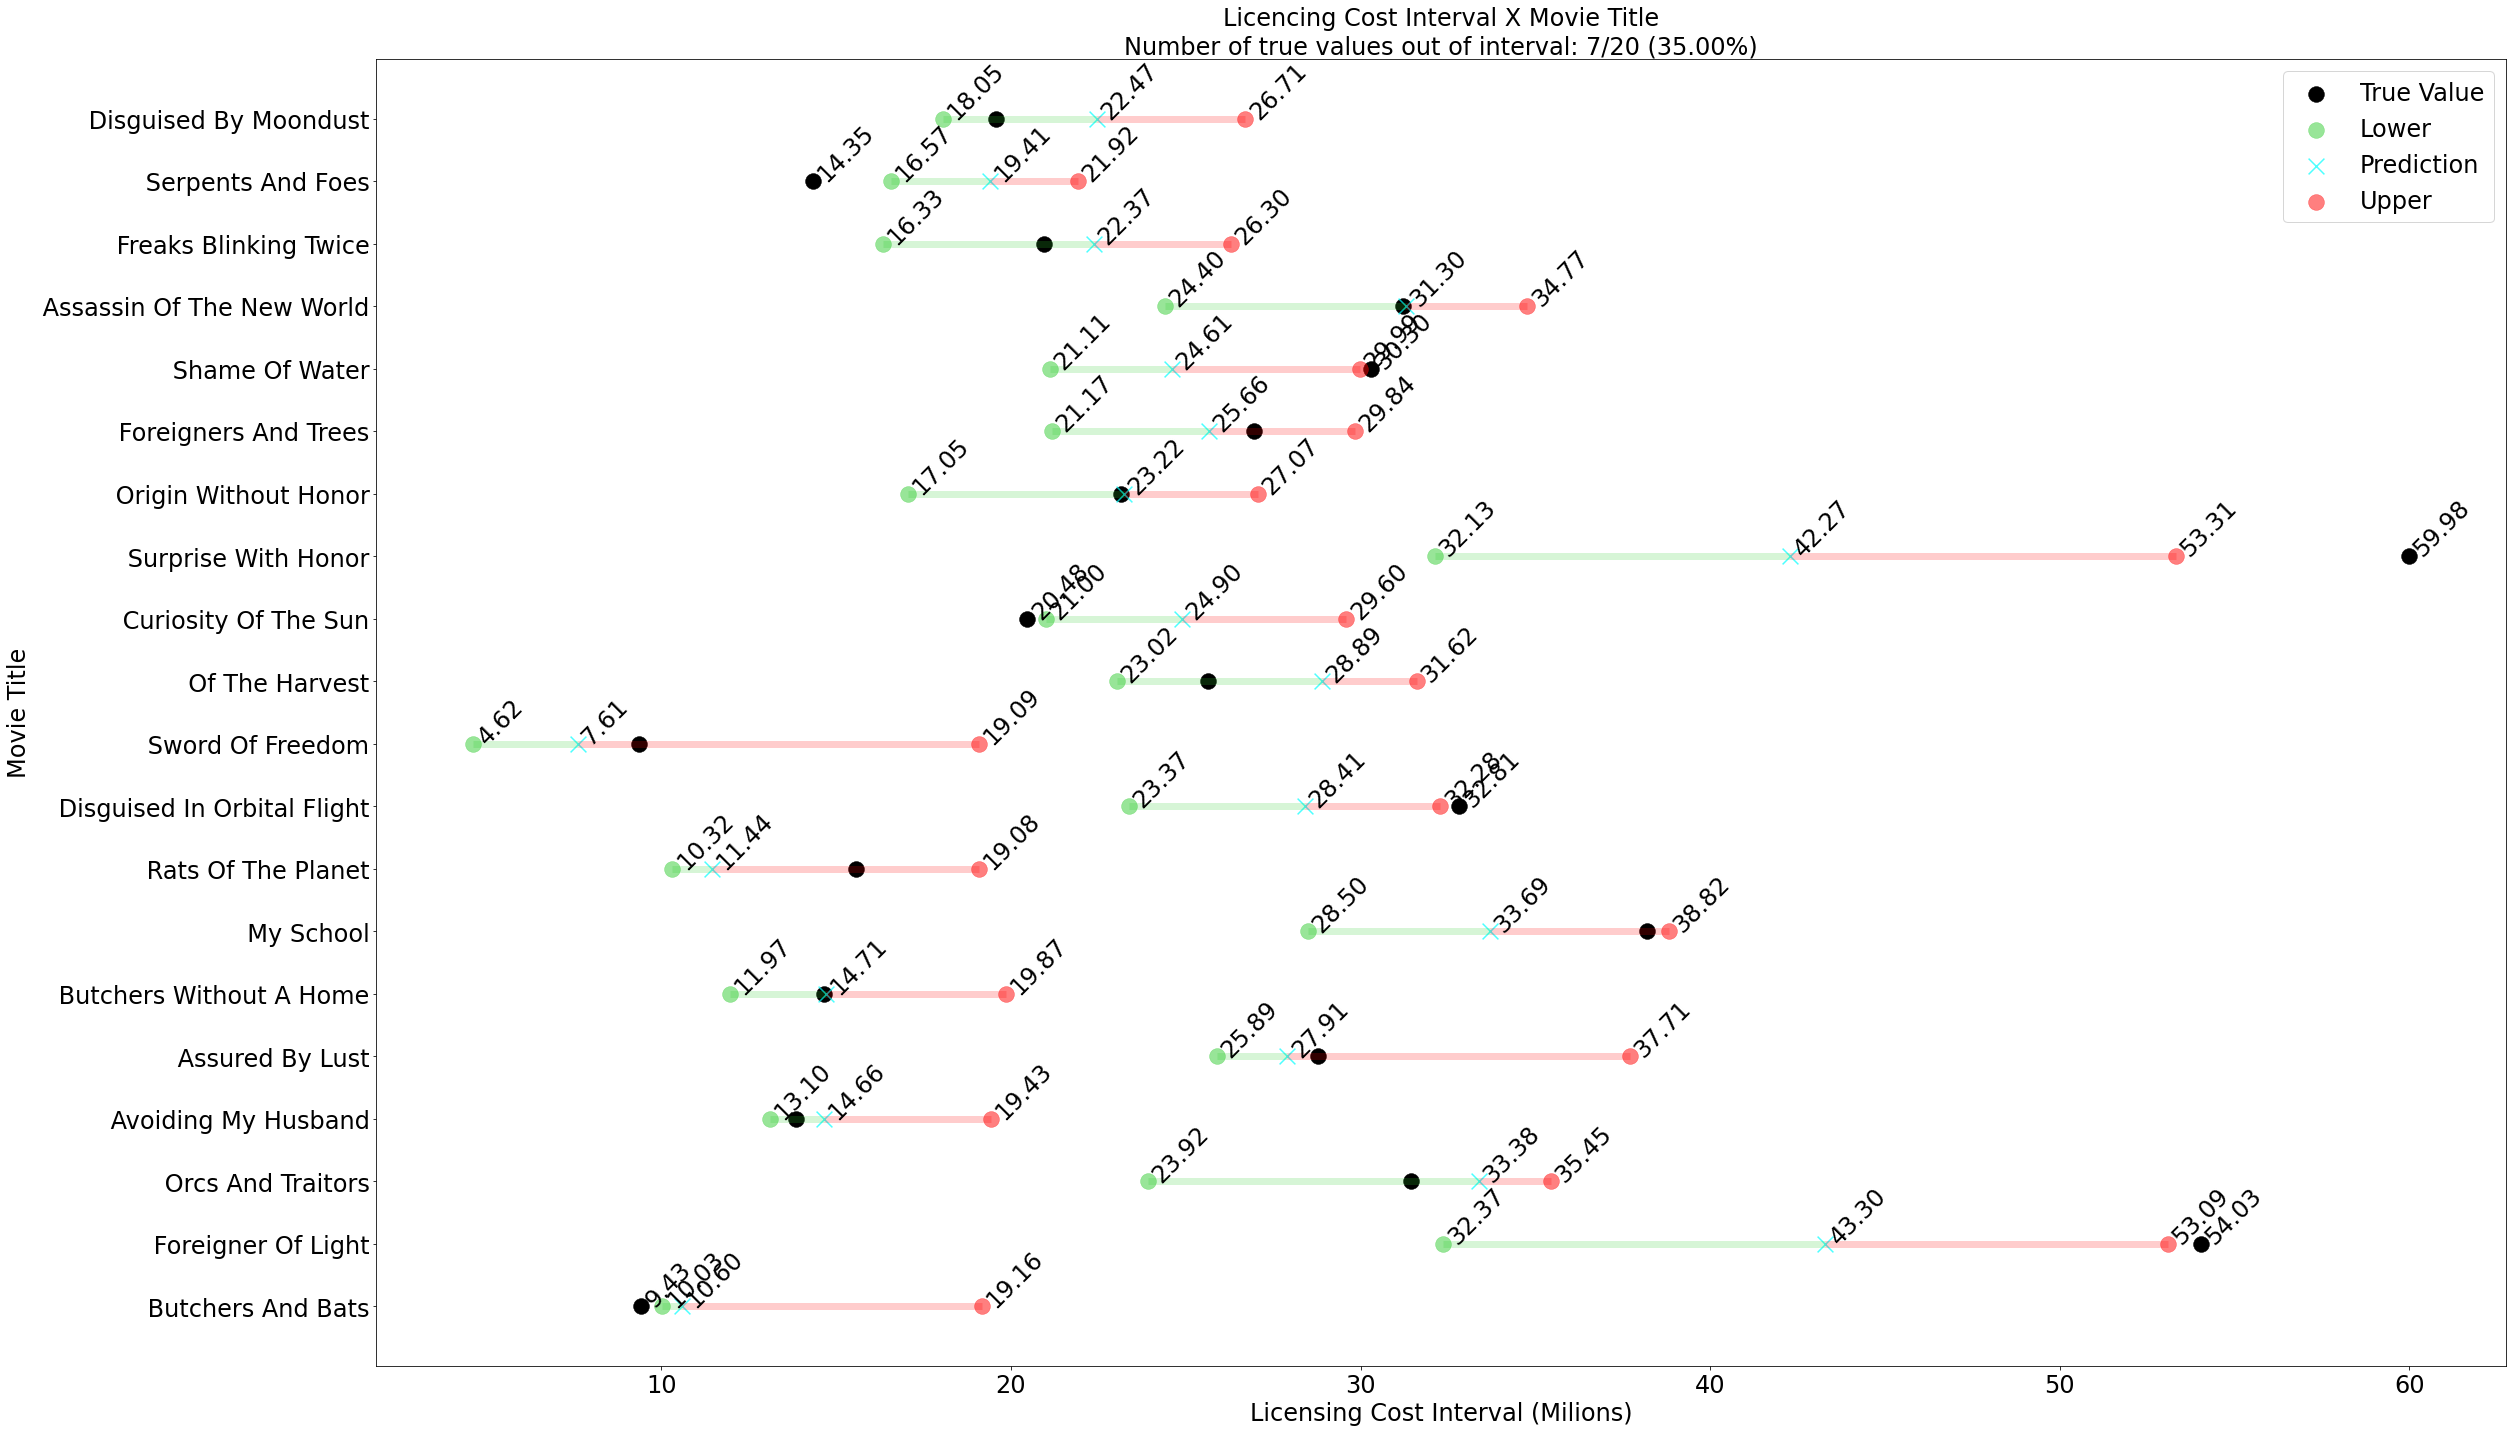

In [14]:
plt.figure(figsize=(35, 20))

out = 0

plt.scatter(y_test, test_titles, color='black', marker='o', label='True Value', lw=0.5, s=250)
for true, title, low, up in zip(y_test, test_titles, lower_pred, upper_pred):
    if true > up or true < low:
        plt.annotate(f'{true:.2f}', (true, title), rotation=45, fontsize=24)
        out += 1

plt.scatter(lower_pred, test_titles, color='limegreen', marker='o', label='Lower', lw=0.5, alpha=0.5, s=250)
for low, title in zip(lower_pred, test_titles):
    plt.annotate(f'{low:.2f}', (low, title), rotation=45, fontsize=24)
plt.scatter(regressor_pred, test_titles, color='aqua', marker='x', label='Prediction', alpha=0.7, s=250)
for pred, title in zip(regressor_pred, test_titles):
    plt.annotate(f'{pred:.2f}', (pred, title), rotation=45, fontsize=24)
plt.scatter(upper_pred, test_titles, color='red', marker='o', label='Upper', lw=0.5, alpha=0.5, s=250)
for up, title in zip(upper_pred, test_titles):
    plt.annotate(f'{up:.2f}', (up, title), rotation=45, fontsize=24)

for title, low, pred, up in zip(test_titles, lower_pred, regressor_pred, upper_pred):
    plt.hlines(title, low, pred, color='limegreen', alpha=0.2, linewidth=7)
    plt.hlines(title, pred, up, color='red', alpha=0.2, linewidth=7)

plt.title(f'Licencing Cost Interval X Movie Title\nNumber of true values out of interval: {out}/{test_titles.shape[0]} ({out/test_titles.shape[0]*100:.2f}%)', fontsize=24)
plt.ylabel('Movie Title', fontsize=24)
plt.xlabel('Licensing Cost Interval (Milions)', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig('Licencing Cost Interval X Movie Title Test Data.png', dpi=600)
plt.show()



A seguir tomo os passos necessários para realizar a predição dos dados reais, os que não sabemos os valores de licenciamento.

In [15]:
#Leitura dos dados de predição
prediction_data = pd.read_excel('prediction_data.xlsx')

#Armazenamento dos titulos para gráficos
prediction_titles = prediction_data['Title']
#Remoção dos títulos
prediction_data = prediction_data.drop(columns=['Title'])
#Remoção de espaços a mais nos nomes dos países e gêneros
prediction_data['Country'] = prediction_data['Country'].str.strip()
prediction_data['Genre'] = prediction_data['Genre'].str.strip()

In [16]:
#Encoding dos dados de predição, utilizando os encodings criados anteriormente
prediction_data['Release Year'] = release_year_enc.transform(prediction_data['Release Year'].to_numpy().reshape(-1, 1)).astype('int')

prediction_data['Country'] = country_enc.transform(prediction_data['Country'].to_numpy().reshape(-1, 1)).astype('int')

prediction_data['Genre'] = genre_enc.transform(prediction_data['Genre'].to_numpy().reshape(-1, 1)).astype('int')


In [17]:
prediction_data

,Genre,Release Year,Duration Minutes,Country,Production Cost In Milions
0,8,1,95,24,97.2
1,5,8,116,22,63.5
2,7,7,129,0,30.4
3,1,1,123,12,83.3
4,4,7,89,19,110.4
5,0,10,105,7,14.7
6,9,5,88,18,97.3


In [18]:
#Utilização dos modelos para predição dos dados
regressor_pred = regressor.predict(prediction_data)
lower_pred = lower.predict(prediction_data)
upper_pred = upper.predict(prediction_data)

O gráfico abaixo é similar ao gráfico anterior, no entanto não existem os valores reais do intervalo.

Com o gráfico abaixo a equipe responsável consegue identificar o mínimo, máximo e valor sugerido pelo modelo para o custo de licenciamento.

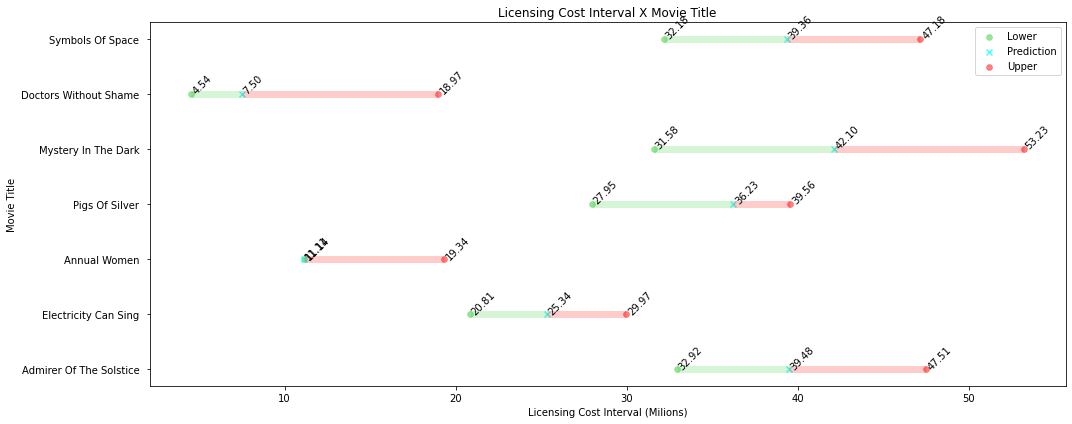

In [19]:
plt.figure(figsize=(15, 6))

plt.scatter(lower_pred, prediction_titles, color='limegreen', marker='o', label='Lower', lw=0.5, alpha=0.5)
for low, title in zip(lower_pred, prediction_titles):
    plt.annotate(f'{low:.2f}', (low, title), rotation=45)
plt.scatter(regressor_pred, prediction_titles, color='aqua', marker='x', label='Prediction', alpha=0.7)
for pred, title in zip(regressor_pred, prediction_titles):
    plt.annotate(f'{pred:.2f}', (pred, title), rotation=45)
plt.scatter(upper_pred, prediction_titles, color='red', marker='o', label='Upper', lw=0.5, alpha=0.5)
for up, title in zip(upper_pred, prediction_titles):
    plt.annotate(f'{up:.2f}', (up, title), rotation=45)

for title, low, pred, up in zip(prediction_titles, lower_pred, regressor_pred, upper_pred):
    plt.hlines(title, low, pred, color='limegreen', alpha=0.2, linewidth=7)
    plt.hlines(title, pred, up, color='red', alpha=0.2, linewidth=7)

plt.title('Licensing Cost Interval X Movie Title')
plt.ylabel('Movie Title')
plt.xlabel('Licensing Cost Interval (Milions)')
plt.legend()
plt.tight_layout()
plt.savefig('Licencing Cost Interval X Movie Title Prediction Data.png', dpi=600)
plt.show()



## Limitações do modelo

A quantidade de dados utilizada pelo modelo é baixa, mas num cenário real a quantidade de dados disponíveis seria maior, o que significa que a ideia do modelo pode ser reaproveitada.

A quantidade de variáveis disponibilizadas, bem como suas naturezas talvez não sejam as mais indicadas para a predição. Frequentemente vemos noticias sobre filmes que não recuperaram seu investimento inicial de produção, por isso outras informações como, elenco, dados que nos informam se a obra é uma adaptação de outro formato, se a obra é uma sequência ou não etc, podem ser mais valiosas.
